Se instalan las bibliotecas necesarias

In [1]:
!pip install opencv-python

Se importan las bibliotecas y módulos necesarios

In [135]:
import glob
import seaborn as sns
import pandas as pd
import matplotlib.image as img
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import numpy as np
from  sklearn.linear_model import LogisticRegression
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [136]:
desire_size = (100, 100)
n_channels = 3
batch_size = 32

In [137]:
labels = list(map(lambda x: x.split("\\")[2], glob.glob("data\\train\\*\\*")))
IDS = list(map(lambda x: x.split("\\")[3], glob.glob("data\\train\\*\\*")))

In [138]:
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
num_out = len(le.classes_)

In [139]:
pd.Series(labels).value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64

Tiene 3 colores (196, 196, 3)


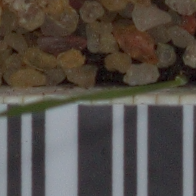

In [140]:
img_color = Image.open(glob.glob(f"data/train/*/{IDS[0]}")[0])
print(f"Tiene 3 colores {np.array(img_color).shape}")
img_color

Tiene 1 canal (196, 196)


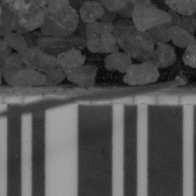

In [141]:
img_gris = img_color.convert('L')
print(f"Tiene 1 canal {np.array(img_gris).shape}")
img_gris

In [142]:
def plot_1_images(d,label, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.imshow(d)
    ax.set_title(label=label)
    return fig,ax

In [143]:
ls_size = []
X = []
y = []
for file in glob.glob("data\\train\\*\\*"):
    label = file.split("\\")[2]
    id_img = file.split("\\")[3]
    # gray scale para tener los 3 colores quite la L
    im = Image.open(file).convert('L')
    ls_size.append([im.size[0],im.size[1],label,id_img])
    img_resize = im.resize(desire_size)
    X.append(np.array(img_resize).flatten())
    y.append(label)

In [144]:
np.array(X).shape

(4750, 10000)

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Sugar beet'}>)

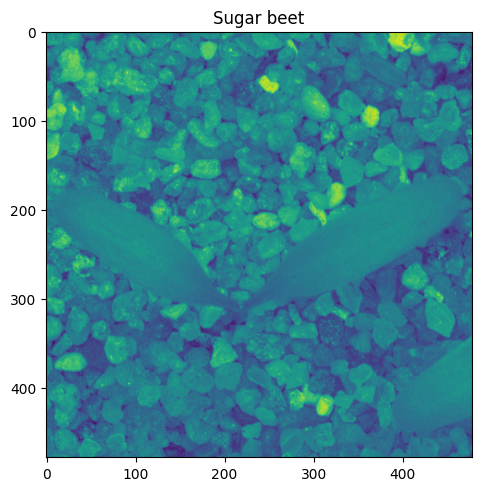

In [145]:
plot_1_images(im,label, ax=None)

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Sugar beet'}>)

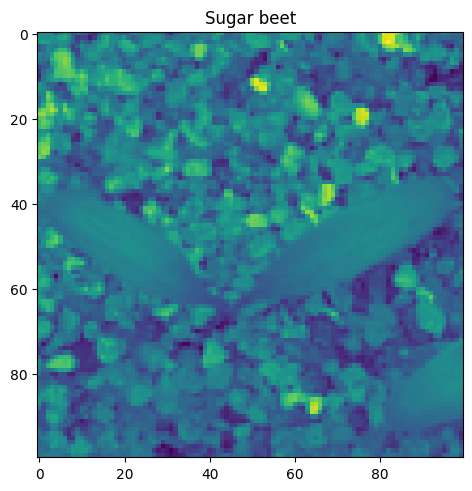

In [146]:
plot_1_images(img_resize,label, ax=None)

In [147]:
# datos ready for CNN
y_img = to_categorical(le.transform(y), dtype ="uint8")
X_img = np.reshape(np.array(X), (-1, desire_size[0], desire_size[1]))
X_train,X_test, y_train,y_test = train_test_split(X_img,y_img,test_size=0.2)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': "['Small-flowered Cranesbill']"}>)

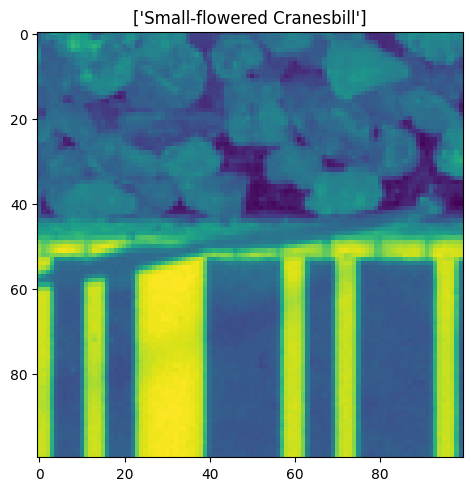

In [148]:
plot_1_images(X_img[0],le.inverse_transform([np.argmax(y_train[0])]), ax=None)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': "['Common Chickweed']"}>)

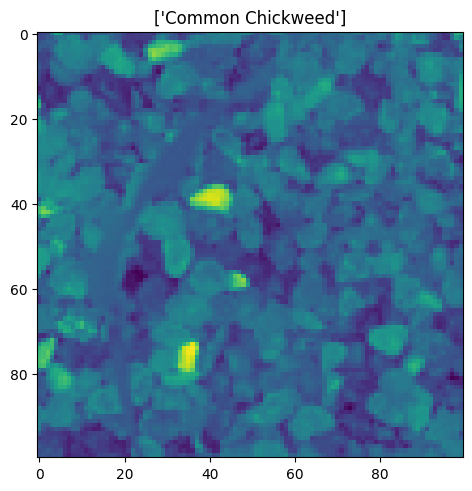

In [149]:
plot_1_images(X_img[1],le.inverse_transform([np.argmax(y_train[1])]), ax=None)

In [150]:
# set a base line
X_train_lg = np.reshape(X_train, (-1, desire_size[0]*desire_size[1]))*1/255
X_test_lg = np.reshape(X_test, (-1, desire_size[0]*desire_size[1]))*1/255
y_train_lg = np.argmax(y_train,axis=1)
y_test_lg = np.argmax(y_test,axis=1)
clf = LogisticRegression(random_state=0,
            solver='lbfgs', max_iter=5000,
            penalty='l2', C=0.1)
clf.fit(X_train_lg, y_train_lg)

LogisticRegression(C=0.1, max_iter=5000, random_state=0)

<Axes: >

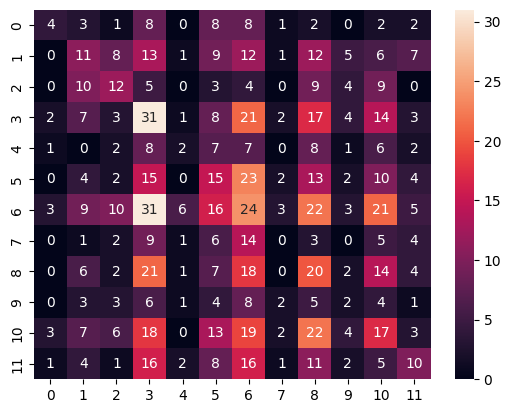

In [151]:
cm = confusion_matrix(y_test_lg, clf.predict(X_test_lg))
sns.heatmap(cm, annot=True, fmt='g')

In [152]:
accuracy_score(y_test_lg, clf.predict(X_test_lg))

0.15578947368421053

In [153]:
X_oob = []
file_oob = []
for file in glob.glob("data\\test\\*"):
    im = Image.open(file).convert('L')
    img_resize = im.resize(desire_size)
    X_oob.append(np.array(img_resize).flatten())
    file_oob.append(file.split("\\")[2])

In [154]:
X_sub_lg = np.reshape(X_oob, (-1, desire_size[0]*desire_size[1]))*1/255
df_oob = pd.DataFrame(data= zip(file_oob, le.inverse_transform(clf.predict(X_test_lg))),
                        columns=["file","species"])

In [155]:
df_oob.to_csv("data/oob_pred.csv", index=False)

In [156]:
# release memory
X_train_lg = X_test_lg = y_train_lg = y_test_lg = None

In [157]:
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=8, input_shape=(desire_size[0],desire_size[1],1),
                 kernel_size=(4,4),padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(200, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# 2nd Fully Connected Layer
model.add(Dense(100, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# 3rd Fully Connected Layer
model.add(Dense(50, activation='relu'))

# Add Dropout
model.add(Dropout(0.1))

# Output Layer
model.add(Dense(num_out, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 100, 100, 8)       136       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 49, 49, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 49, 49, 16)        1168      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 32)        2080      
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 64)       

In [158]:
model.fit(X_train,y_train,  epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
119/119 [==============================] - 24s 193ms/step - loss: 2.6694 - accuracy: 0.1279 - val_loss: 2.3918 - val_accuracy: 0.1716
Epoch 2/5
119/119 [==============================] - 22s 189ms/step - loss: 2.3465 - accuracy: 0.1745 - val_loss: 2.3592 - val_accuracy: 0.1874
Epoch 3/5
119/119 [==============================] - 23s 191ms/step - loss: 2.2639 - accuracy: 0.2066 - val_loss: 2.1395 - val_accuracy: 0.2916
Epoch 4/5
119/119 [==============================] - 23s 190ms/step - loss: 1.9937 - accuracy: 0.3074 - val_loss: 2.0364 - val_accuracy: 0.3274
Epoch 5/5
119/119 [==============================] - 22s 188ms/step - loss: 1.7293 - accuracy: 0.3955 - val_loss: 1.8144 - val_accuracy: 0.3905


In [159]:
#oob = Out Of Bag
X_oob_img = np.reshape(np.array(X_oob), (-1, desire_size[0], desire_size[1]))
y_hat = le.inverse_transform(np.argmax(model.predict(X_oob_img), axis=1))
df_oob = pd.DataFrame(data= zip(file_oob, y_hat),
                        columns=["file","species"])
df_oob.to_csv("data/prediction_cnn.csv", index=False)

25/25 [==============================] - 1s 42ms/step


In [160]:
# read files from directory https://www.tensorflow.org/tutorials/images/classification
# it uses generators to reduce the memory
desire_size = (30,30)
train_ds = tf.keras.utils.image_dataset_from_directory(
  "data/train/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=desire_size,
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  "data/train/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=desire_size,
  batch_size=batch_size)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4750 files belonging to 12 classes.
Using 3800 files for training.
Found 4750 files belonging to 12 classes.
Using 950 files for validation.


In [161]:
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


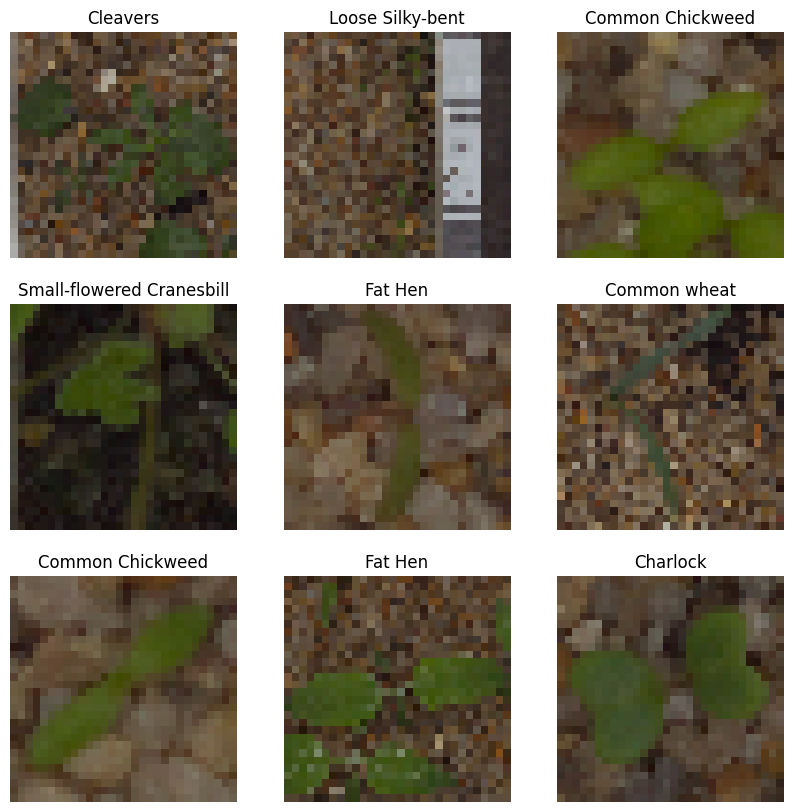

In [162]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [163]:
# network using all the channels
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(desire_size[0], desire_size[1], 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_out)
])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [164]:
epochs=4
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
119/119 [==============================] - 7s 47ms/step - loss: 2.3236 - accuracy: 0.1816 - val_loss: 1.9345 - val_accuracy: 0.2863
Epoch 2/4
119/119 [==============================] - 2s 20ms/step - loss: 1.7934 - accuracy: 0.3442 - val_loss: 1.6008 - val_accuracy: 0.4232
Epoch 3/4
119/119 [==============================] - 2s 20ms/step - loss: 1.5716 - accuracy: 0.4311 - val_loss: 1.5724 - val_accuracy: 0.4105
Epoch 4/4
119/119 [==============================] - 2s 20ms/step - loss: 1.3932 - accuracy: 0.5071 - val_loss: 1.2642 - val_accuracy: 0.5758


In [165]:
y_hat = []
f = '24c94a6ca.png'
img = tf.keras.utils.load_img(
    f"data/test/{f}", target_size=desire_size
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])
y_hat.append(score.numpy())
y_hat

1/1 [==============================] - 0s 113ms/step


[array([0.00921094, 0.07281972, 0.1592514 , 0.01227929, 0.03176326,
        0.16129749, 0.01777059, 0.01272472, 0.14549443, 0.03532203,
        0.01099951, 0.33106664], dtype=float32)]